**Climate Analysis of Aspen, Colorado Using Temperature Data from 1980 to 2025**

In [31]:
# Import required packages
import earthpy # Helps with downloading climate data
import pandas as pd # Helps with calculations and data transformations
import matplotlib.pyplot as plt # Create plots
from sklearn.linear_model import LinearRegression # Create interactive plots!
import numpy as np # Helps with calculations and data transformations
import hvplot.pandas # Interactive plotting feature
import holoviews as hv # This helps with formatting the interactive trendline plot
from bokeh.models import NumeralTickFormatter # This helps with formatting the interactive trendline plot

Searching for stations can be difficult. There are many stations that don't have a long enough timespan (< 30 years), or the % coverage is not high enough. I finally found this station in Aspen, which has 99% coverage from 1980 to present. 

I used this link to search for stations: https://www.ncei.noaa.gov/cdo-web/search?datasetid=GHCND

In [32]:
#Load the station data for Aspen from the NCEI website
aspen_station = ('https://www.ncei.noaa.gov/access/services/da'
'ta/v1?dataset=daily-summaries&dataTypes=TOBS&stations=USC00050372&startDate=1980-07-01&endDate=2025-07-31&units=standard')
aspen_station

'https://www.ncei.noaa.gov/access/services/data/v1?dataset=daily-summaries&dataTypes=TOBS&stations=USC00050372&startDate=1980-07-01&endDate=2025-07-31&units=standard'

In [33]:
# Download the climate data in Python
aspen_climate_df = pd.read_csv(
    aspen_station,
    index_col='DATE',
    parse_dates=True,
    na_values=['NaN']
)

# Check that the download worked
aspen_climate_df.head()

,STATION,TOBS
DATE,,
1980-07-01,USC00050372,62.0
1980-07-02,USC00050372,55.0
1980-07-03,USC00050372,58.0
1980-07-04,USC00050372,60.0
1980-07-05,USC00050372,50.0


In [34]:
# Save the climate data
aspen_climate_df.to_csv('aspen_temp_data.csv')

In [35]:
# Check that data was imported into a pandas DataFrame
type(aspen_climate_df)

pandas.core.frame.DataFrame

In [36]:
# Remove station column in dataframe 
# We are only using 1 station, so don't need this column
aspen_climate_df = aspen_climate_df[["TOBS"]]
aspen_climate_df

,TOBS
DATE,
1980-07-01,62.0
1980-07-02,55.0
1980-07-03,58.0
1980-07-04,60.0
1980-07-05,50.0
...,...
2025-07-27,61.0
2025-07-28,54.0
2025-07-29,62.0


In [37]:
# Rename the column name to a more descriptive name
aspen_units_f = aspen_climate_df.rename(columns={
    'TOBS': 'temp_f',
})
aspen_units_f

,temp_f
DATE,
1980-07-01,62.0
1980-07-02,55.0
1980-07-03,58.0
1980-07-04,60.0
1980-07-05,50.0
...,...
2025-07-27,61.0
2025-07-28,54.0
2025-07-29,62.0


In [38]:
#Adding a column of temp converted to C
aspen_units_c_f = aspen_units_f
aspen_units_c_f['temp_c'] = ((aspen_units_f['temp_f']-32)*5/9)

#Create a new dataframe with just temp C
aspen_units_c = aspen_units_c_f[["temp_c"]]
aspen_units_c

,temp_c
DATE,
1980-07-01,16.666667
1980-07-02,12.777778
1980-07-03,14.444444
1980-07-04,15.555556
1980-07-05,10.000000
...,...
2025-07-27,16.111111
2025-07-28,12.222222
2025-07-29,16.666667


<Axes: title={'center': 'Aspen Daily Temperature Data From 1980 to 2025'}, xlabel='Date', ylabel='Temperature (C)'>

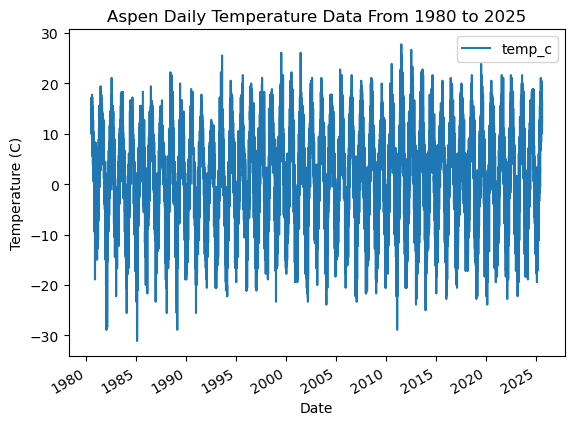

In [39]:
# Plot the data using .plot
aspen_units_c.plot(
    y='temp_c',
    title='Aspen Daily Temperature Data From 1980 to 2025',
    xlabel='Date',
    ylabel='Temperature (C)')

From the graph above, we can see that we are plotting daily temperature which doesn't give us a very good picture of the longer term climate. In the next step, we will resample the data to annual average temperature values which should help give a clearer representation of the climate. 

In [40]:
# Using pandas to resample from daily to annual temperature
# 'YS' stands for 'Year Begin' in pandas
# Below we are resampling to once a year (YS), and recording the mean temperature of each year
# We are saving the new resampled data in the dataframe called aspen_ann_climate_df
# This new dataframe should have just one temp value per year
aspen_ann_climate_df = (
    aspen_units_c
    .resample('YS') 
    .mean()
)

<Axes: title={'center': 'Annual Average Temperature in Aspen From 1980 to 2025'}, xlabel='Year', ylabel='Temperature (°C)'>

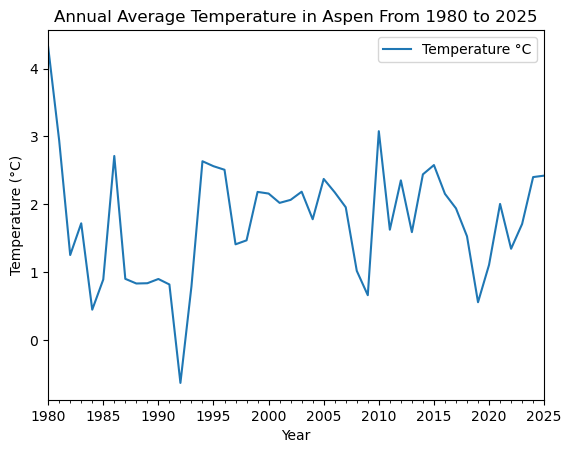

In [41]:
# Plot the annual data
aspen_ann_climate_df.plot(
    y='temp_c',
    title='Annual Average Temperature in Aspen From 1980 to 2025',
    xlabel='Year',
    ylabel='Temperature (°C)',
    label='Temperature °C'
)

In [42]:
# Create an interactive version using hvplot
interactive_plot = aspen_ann_climate_df.hvplot(
    y="temp_c",
    title="Annual Average Temperature in Aspen From 1980 to 2025",
    xlabel="Year",
    ylabel="Temperature (°C)",
    label="Temperature (°C)"
)
interactive_plot

:Curve   [DATE]   (temp_c)

There is quite a bit of variability in this annual data, and it's hard to discern a clear trend. Therefore, this is a good use case for fitting a trendline using linear regression. I will use the Linear Ordinary Least Squares (OLS) Regression method where I'll need to calculate the slope and intercept from the data.

In [43]:
# Workflow for fitting trendline.
# Need to reset the index to make sure that the 'DATE' column is recognized
aspen_ann_climate_df = aspen_ann_climate_df.reset_index()

# Convert 'DATE' column values to pandas datetime objects
# It is easier to extract just the year if the values are in this format
aspen_ann_climate_df["DATE"] = pd.to_datetime(aspen_ann_climate_df["DATE"])

# The line below is extracting just the year (we don't want months or days)
aspen_ann_climate_df["Year"] = aspen_ann_climate_df["DATE"].dt.year

# Remove Nan values. The Linear regression will run into errors if we keep the Nan values
aspen_ann_climate_df_clean = aspen_ann_climate_df.dropna(subset=["temp_c"])

# Assigning the X and y values for the linear regression feature from sklearn
# This creates numpy arrays of the year and temp columns
X = aspen_ann_climate_df_clean[["Year"]].values
y = aspen_ann_climate_df_clean["temp_c"].values

# Method for running the linear regression using sklearn
model = LinearRegression()
model.fit(X, y)

# finding the slope with .coef_
slope = model.coef_[0]

# finding the intercept with .intercept
intercept = model.intercept_

print("Slope:", round(slope, 4), "°C per year")
print("Intercept:", round(intercept, 4))

Slope: 0.0061 °C per year
Intercept: -10.5503


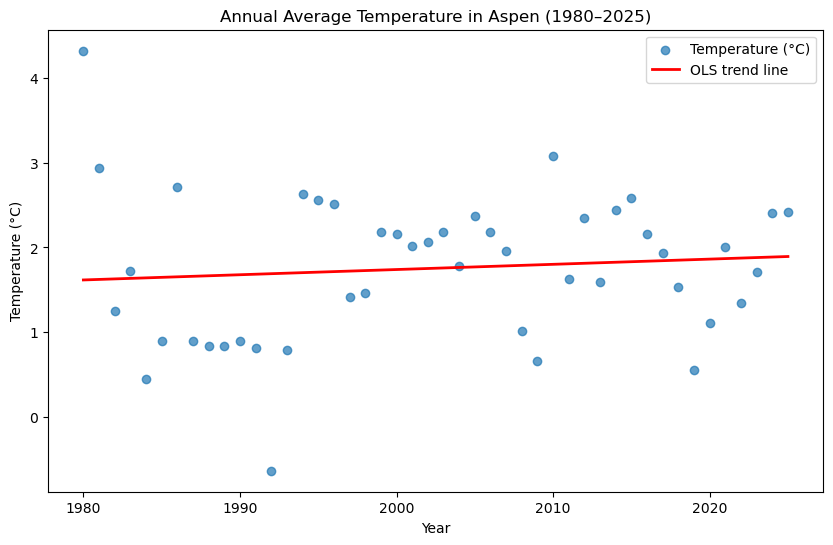

In [44]:
# Create a new figure object using matplotlib and define its size
plt.figure(figsize=(10, 6))

# Plot the temperature data
plt.scatter(
    aspen_ann_climate_df["Year"],
    aspen_ann_climate_df["temp_c"],
    label="Temperature (°C)",
    alpha=0.7
)

# The line below finds the min and max of "year"
# This way, our trendline won't extend off the graph of the temp data
x_vals = np.linspace(
    aspen_ann_climate_df["Year"].min(),
    aspen_ann_climate_df["Year"].max()
)

# Applying the y=mx+b formula for lines
y_trend = slope * x_vals + intercept

# plotting the line
plt.plot(
    x_vals,
    y_trend,
    color="red",
    linewidth=2,
    label="OLS trend line"
)

# Labels and title
plt.title("Annual Average Temperature in Aspen (1980–2025)")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.legend()

plt.show()


This graph, as well as the slope we calculated earlier shows that there is a small increase in average temperature from 1980 to 2025 in Aspen. **I calculated an increase of 0.0061 °C per year since 1980, and over 45 years, this is a total increase of 0.2745 °C.** While this number sounds relatively small, if this trend continues, this could pose a serious problem for Aspen's winter economy as well as the mountain ecosystems and climate as a whole. I'm interesting in continuing to look for more temperature data in Aspen going back farther before 1980 to better understand this trend in Aspen's climate.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
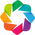

Slope: 0.0061 °C/year
Intercept: -10.5503


:Overlay
   .Scatter.Temperature_left_parenthesis_degree_C_right_parenthesis :Scatter   [Year]   (temp_c)
   .Curve.OLS_trend_line                                            :Curve   [Year]   (OLS trend line)

In [45]:
# With the help of ChatGPT, I created this interactive plot that includes the trendline.
# Ensure Bokeh is the backend for hvplot
hv.extension("bokeh")

# linear regression
X = aspen_ann_climate_df_clean[["Year"]].values
y = aspen_ann_climate_df_clean["temp_c"].values

model = LinearRegression()
model.fit(X, y)

slope = model.coef_[0]
intercept = model.intercept_

print("Slope:", round(slope, 4), "°C/year") # round to 4 decimals
print("Intercept:", round(intercept, 4))

# plot observed data 
interactive_plot = aspen_ann_climate_df_clean.hvplot.scatter(
    x="Year",
    y="temp_c",
    alpha=0.7,
    label="Temperature (°C)",
    xlabel="Year",
    ylabel="Temperature (°C)",
    title="Annual Average Temperature in Aspen (1980–2025)",
    size=6,
    color="blue",
    nan_policy="raise"
)

# Generate trendline points
x_vals = np.linspace(
    aspen_ann_climate_df_clean["Year"].min(),
    aspen_ann_climate_df_clean["Year"].max(),
    100
)
y_trend = slope * x_vals + intercept

# Convert trendline into a dataframe so hvplot can plot it
trend_df = pd.DataFrame({
    "Year": x_vals.astype(int),  # integer years
    "OLS trend line": y_trend
})

trend_plot = trend_df.hvplot.line(
    x="Year",
    y="OLS trend line",
    color="red",
    line_width=2,
    label="OLS trend line"
)

# function to center title and fix year formatting
def format_plot(plot, element):
    plot.state.title.align = "center"
    plot.state.xaxis.formatter = NumeralTickFormatter(format="0")  # force integer year labels

# Combine plots and apply formatting
final_plot = (interactive_plot * trend_plot).opts(
    title="Annual Average Temperature in Aspen (1980–2025)",
    hooks=[format_plot],
    framewise=True,
    padding=0.05,
    legend_position="top_right"
)

import hvplot
hvplot.save(final_plot, "aspen_temp_interactive.html")

final_plot